In [47]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import math
import sys

# Load the sample data                                                                 
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')


X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

In [46]:
def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix 
    
    # IMPLEMENT THIS METHOD 
    a = np.unique(y)
    means = np.zeros((len(a), X.shape[1]))
    for i in a:
        x1 = X[np.where(y == i)[0]]
        means[int(i)-1] = x1.mean(axis=0)
    covmat = np.cov(X.T)
    return means, covmat

def qdaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes
    
    # IMPLEMENT THIS METHOD
    covmats = []
    labels = np.unique(y)
    means = np.zeros([labels.shape[0],X.shape[1]])

    for i in range(labels.shape[0]):
        m = np.mean(X[np.where(y == labels[i])[0],],axis=0)
        means[i,] = m
        covmats.append(np.cov(np.transpose(X[np.where(y == labels[i])[0],])))
    return means, covmats

In [48]:
def ldaTest(means,covmat,Xtest,ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    g = 1 / np.sqrt((2*np.pi**means.shape[1])*det(covmat))
    ll = np.zeros((Xtest.shape[0], means.shape[0]))
    for i in range(Xtest.shape[0]):
        for h in range(means.shape[0]):
            b = Xtest[i, :] - means[int(h) - 1]
            t = (-1/2)*np.dot(np.dot(b.T, inv(covmat)), b)
            ll[i,int(h)-1] = g * np.e**t 
            
    ypred = []
    for row in ll:
        ypred.append(list(row).index(max(list(row)))+1)
    #ypred = np.argmax(ll, axis=1)+1
    
    acc = 0
    for k in range(len(ypred)):
        if ypred[k] == ytest[k]:
            acc += 1
    acc = acc / len(ypred)
    ytest=ytest.flatten()
    return acc, np.array(ypred)

def qdaTest(means,covmats,Xtest,ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    a = np.unique(ytest)
    ll = np.zeros((Xtest.shape[0], means.shape[0]))
    for i in range(Xtest.shape[0]):
        for h in range(means.shape[0]):
            index = int(h)-1
            b = Xtest[i, :] - means[index]
            t = (-1/2)*np.dot(np.dot(b.T, inv(covmats[index])), b)
            g = 1 / np.sqrt((2*np.pi**means.shape[1])*det(covmats[index]))
            ll[i,index] = g * np.e**t 
            
    ypred = []
    for row in ll:
        ypred.append(list(row).index(max(list(row)))+1)
    #ypred = np.argmax(ll, axis=1)+1
    
    acc = 0
    for k in range(len(ypred)):
        if ypred[k] == ytest[k]:
            acc += 1
    acc = acc / len(ypred)
    ytest=ytest.flatten()
    return acc, np.array(ypred)

In [49]:
# LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))
# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))


LDA Accuracy = 0.97
QDA Accuracy = 0.96


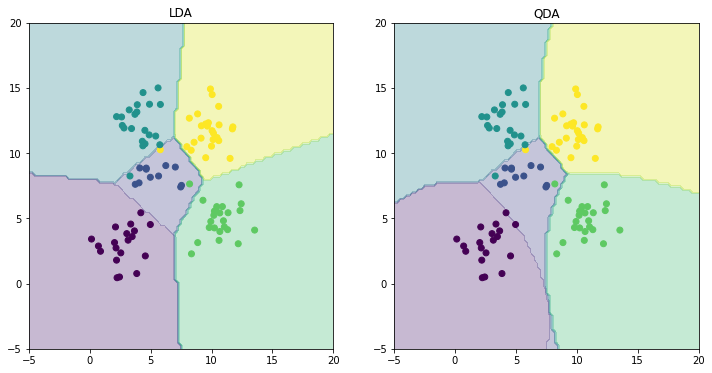

In [50]:
# Plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest[:,0])
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest[:,0])
plt.title('QDA')

plt.show()

In [51]:
def learnRidgeRegression(X,y,lambd):
    wRR_list = []
    df_list = []
    
    for i in range(0, 5001, 1):
        xtranspose = np.transpose(X)
        xtransx = np.dot(xtranspose, X)
        if xtransx.shape[0] != xtransx.shape[1]:
            raise ValueError('Needs to be a square matrix for inverse')
        lamidentity = np.identity(xtransx.shape[0]) * lambd
        matinv = np.linalg.inv(lamidentity + xtransx)
        xtransy = np.dot(xtranspose, y)
        wRR = np.dot(matinv, xtransy)
        _, S, _ = np.linalg.svd(X)
        df = np.sum(np.square(S) / (np.square(S) + lambd))
        wRR_list.append(wRR)
        df_list.append(df)
    return wRR_list, df_list

In [52]:
def learnOLERegression(X,y):
    # Inputs:
    # X = N x d
    # y = N x 1
    # Output:
    # w = d x 1

    # IMPLEMENT THIS METHOD
    # converstions from the 2nd j(w)formula given
    transposed_x = np.transpose(X)                       #flip flops the matrix
    #manupulating the dimensions for proper calculations
    dot_x = np.dot(transposed_x , X)			 #product of x and the flop(inv) of x
    dot_y = np.dot(transposed_x , y)                     #product of y and the flop(inv) of x
    inverse = np.linalg.inv(dot_x)                       #inverse of the dot_x
    w = np.dot(inverse, dot_y)                           #calculating the wight
    return w

#Aakanksha : Problem 2
def testOLERegression(w,Xtest,ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # mse

    # IMPLEMENT THIS METHOD
    #literal converstion from the formula given
    xw = np.dot(Xtest,w)
    sub = np.subtract(ytest,xw)
    sqDif = np.square(sub)                                #subtracts the dot product of the w and the x from $
    rmse = np.sum(sqDif)                                  #performs a summition
    N = Xtest.shape[0]                                    #gets the sphape of xtest so that we can get N
    mse = np.divide(rmse,N)
    return mse

# Andrew
def learnRidgeRegression(X,y,lambd):
    # Inputs:
    # X = N x d                                                               
    # y = N x 1 
    # lambd = ridge parameter (scalar)
    # Output:                                                                  
    # w = d x 1                                                                

    # IMPLEMENT THIS METHOD    
    # https://onlinecourses.science.psu.edu/stat857/node/155
    
    N, d = np.shape(X)
    
    XT_dot_X = np.dot(X.T,X)
    lambd_eye = lambd*np.eye(d)
    sum_X_I_inv = np.linalg.inv( XT_dot_X + lambd_eye )
    XT_dot_y = np.dot(X.T, y)
    w = np.dot(sum_X_I_inv, XT_dot_y)
	
    return w

# Dom : Problem 4
def regressionObjVal(w, X, y, lambd):
    
    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda
    
    # IMPLEMENT THIS METHOD
    #https://www.cs.utah.edu/~piyush/teaching/6-9-print.pdf
    N = X.shape[0]
    w = np.mat(w).T
    y_Xdw = y - np.dot(X, w) 
                      
    
    error = 0.001  * ( np.dot(y_Xdw.T, y_Xdw) + (lambd * np.dot(w.T, w)) )
    learning_rate =  0.0005
    error_grad =  X.T.dot(X.dot(w) - y) * learning_rate
#    error_grad = (((((w.T).dot((X.T).dot(X))) - ((y.T).dot(X))) / N) + ((w.T) * lambd)).T
    error_grad = np.ndarray.flatten(np.array(error_grad))
    return error, error_grad

# Aakanksha : Problem 5
def mapNonLinear(x,p):
    # Inputs:                                                                  
    # x - a single column vector (N x 1)                                       
    # p - integer (>= 0)                                                       
    # Outputs:                                                                 
    # Xd - (N x (d+1)) 
	
    # IMPLEMENT THIS METHOD
    shape = x.shape[0]               # gets the shape of x
    N = p+1                          # N = p + 1
    Xd = np.ones((shape,N))          # matrix Xd = (shape of x ) x N
    for i in range(1, N):            # looping to assign through out the
        Xd[:, i] = math.pow(x,i)     # assign x^i to the array xd we are making it linear
    return Xd

MSE without intercept mean of magnitude of weights: 73056.76434134899
MSE with intercept mean of magnitude of weights: 4408.784304987702
MSE without intercept 106775.36156176544
MSE with intercept 3707.8401817245654


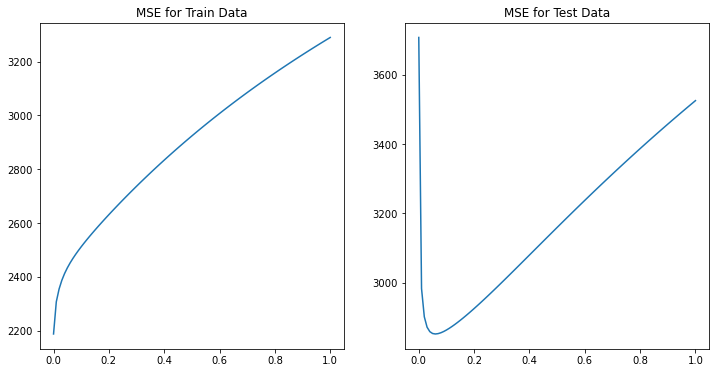

In [54]:
w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)
print("MSE without intercept mean of magnitude of weights: {}".format(np.mean(np.absolute(w))))

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)
print("MSE with intercept mean of magnitude of weights: {}".format(np.mean(np.absolute(w_i))))

print('MSE without intercept '+str(mle))
print('MSE with intercept '+str(mle_i))

# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
w_l_list = []
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    w_l_list.append(w_l)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')

plt.show()

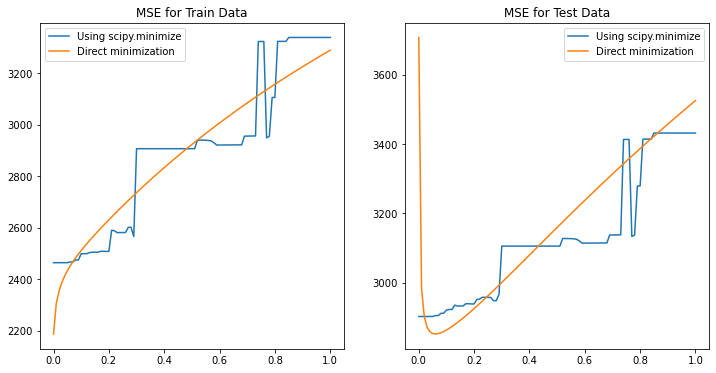

TypeError: only size-1 arrays can be converted to Python scalars

In [55]:
# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.                                                
w_init = np.ones((X_i.shape[1],1))
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()


# Problem 5
pmax = 7
lambda_opt = lambdas[np.argmin(mses3)] 
mses5_train = np.zeros((pmax,2))
mses5 = np.zeros((pmax,2))
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0)
    mses5_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    mses5_train[p,1] = testOLERegression(w_d2,Xd,y)
    mses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses5_train)
plt.title('MSE for Train Data')
plt.legend(('No Regularization','Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses5)
plt.title('MSE for Test Data')
plt.legend(('No Regularization','Regularization'))
plt.show()